In [ ]:
# Import libraries and check folder structure

import os
from pprint import pprint

# Set your base path to where the dataset is extracted
dataset_path = "C:/Users/radio/Documents/Sem VI/Data Analytics and Visualization Lab/DAV Project/Chest_X-Ray_Dataset"

# Check folder structure
for split in ['train', 'val', 'test']:
    print(f"\nContents of '{split}' folder:")
    split_path = os.path.join(dataset_path, split)
    class_folders = os.listdir(split_path)
    for cls in class_folders:
        cls_path = os.path.join(split_path, cls)
        num_images = len(os.listdir(cls_path))
        print(f" - {cls}: {num_images} images")


Contents of 'train' folder:
 - COVID19: 460 images
 - NORMAL: 1341 images
 - PNEUMONIA: 3875 images
 - TURBERCULOSIS: 650 images

Contents of 'val' folder:
 - COVID19: 10 images
 - NORMAL: 8 images
 - PNEUMONIA: 8 images
 - TURBERCULOSIS: 12 images

Contents of 'test' folder:
 - COVID19: 106 images
 - NORMAL: 234 images
 - PNEUMONIA: 390 images
 - TURBERCULOSIS: 41 images


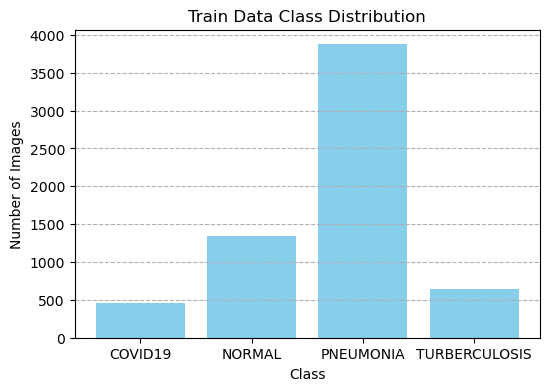

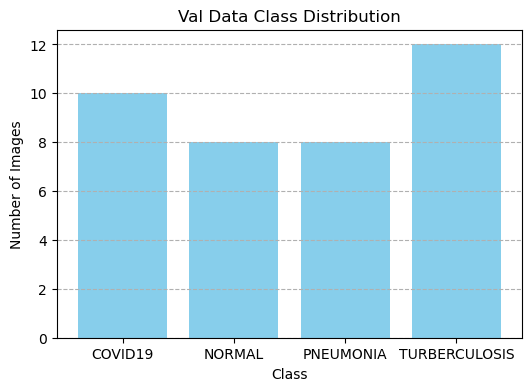

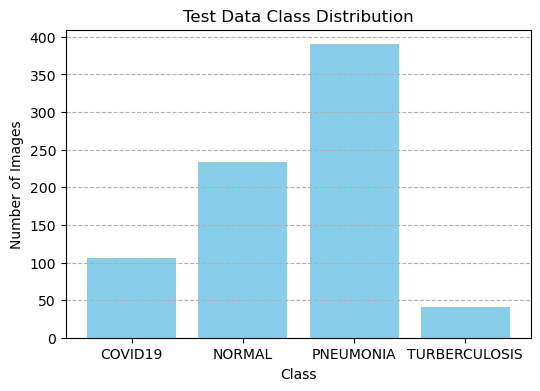

In [ ]:
# Pre-Feature-Extraction Visualizations

# Bar Chart - Classs Distribution per Dataset Split

import os
import matplotlib.pyplot as plt

splits = ['train', 'val', 'test']
class_counts = {}

for split in splits:
    split_path = os.path.join(dataset_path, split)
    class_counts[split] = {}
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        class_counts[split][cls] = len(os.listdir(cls_path))

# Bar chart for each split
for split in splits:
    classes = list(class_counts[split].keys())
    counts = list(class_counts[split].values())
    
    plt.figure(figsize=(6,4))
    plt.bar(classes, counts, color='skyblue')
    plt.title(f'{split.capitalize()} Data Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.grid(axis='y', linestyle='--')
    plt.show()


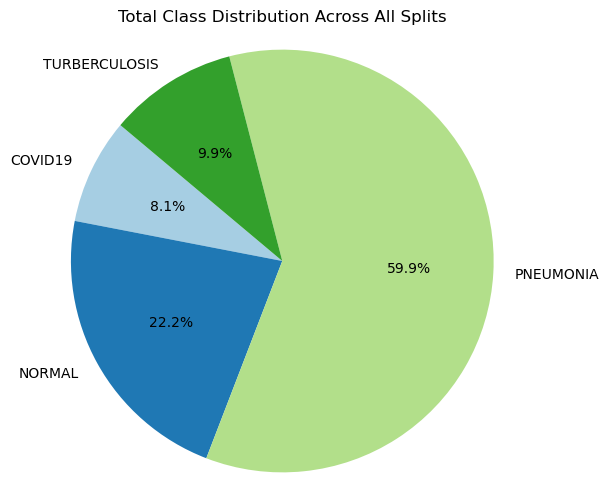

In [ ]:
# Pie Chart - Overall Class Prportion

total_counts = {}
for split in class_counts:
    for cls, count in class_counts[split].items():
        total_counts[cls] = total_counts.get(cls, 0) + count

plt.figure(figsize=(6,6))
plt.pie(total_counts.values(), labels=total_counts.keys(), autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Total Class Distribution Across All Splits')
plt.axis('equal')
plt.show()

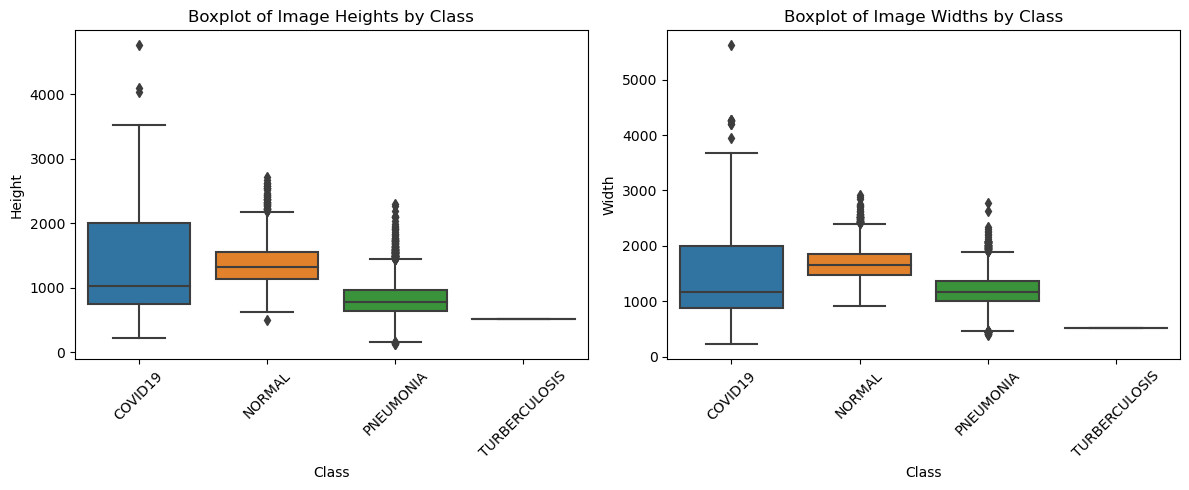

In [ ]:
# Box Plot - Image Dimension Distribution (Height and Width)

import cv2
import seaborn as sns
import pandas as pd

# Gather image dimensions
image_dims = []

for split in splits:
    split_path = os.path.join(dataset_path, split)
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        for img_file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_file)
            try:
                img = cv2.imread(img_path)
                h, w, _ = img.shape
                image_dims.append({'Split': split, 'Class': cls, 'Height': h, 'Width': w})
            except:
                continue  # Skip corrupted images

# Create DataFrame
dim_df = pd.DataFrame(image_dims)

# Boxplot for height and width
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.boxplot(data=dim_df, x='Class', y='Height')
plt.title('Boxplot of Image Heights by Class')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=dim_df, x='Class', y='Width')
plt.title('Boxplot of Image Widths by Class')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Feature Extraction per Image

import numpy as np
import pandas as pd
import cv2
from scipy.stats import skew, kurtosis

def calculate_entropy(gray):
    hist = cv2.calcHist([gray], [0], None, [256], [0,256]).ravel()
    hist = hist / hist.sum()
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

def extract_features(img_path):
    try:
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        total_pixels = h * w

        # Basic stats
        mean_val = np.mean(gray)
        std_val = np.std(gray)
        med_val = np.median(gray)
        skew_val = skew(gray.ravel())
        kurt_val = kurtosis(gray.ravel())

        # Intensity info
        contrast = gray.max() - gray.min()
        entropy_val = calculate_entropy(gray)

        # Threshold-based percentages
        percent_white = np.sum(gray > 200) / total_pixels
        percent_black = np.sum(gray < 50) / total_pixels

        # Focus and edge
        lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        edges = cv2.Canny(gray, 100, 200)
        edge_density = np.sum(edges > 0) / total_pixels

        # Shape
        aspect_ratio = w / h
        area = total_pixels

        # Mode using histogram
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        mode_val = np.argmax(hist)

        return [
            mean_val, std_val, skew_val, kurt_val, med_val,
            contrast, entropy_val, percent_white, percent_black,
            lap_var, edge_density, aspect_ratio, area, mode_val
        ]
    except:
        return [None]*15  # For corrupted or unreadable files

In [ ]:
# Run Feature Extraction for All Images

import tqdm

features_data = []
feature_names = [
    "mean_intensity", "std_intensity", "skewness", "kurtosis", "median_intensity",
    "contrast", "entropy", "percent_white_pixels", "percent_black_pixels",
    "variance_of_laplacian", "edge_density", "aspect_ratio", "area", "mode_intensity"
]

for split in splits:
    split_path = os.path.join(dataset_path, split)
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        for img_file in tqdm.tqdm(os.listdir(cls_path), desc=f"{split}/{cls}"):
            img_path = os.path.join(cls_path, img_file)
            features = extract_features(img_path)
            features_data.append([split, cls, img_file] + features)

# Create DataFrame
columns = ["split", "class", "filename"] + feature_names
features_df = pd.DataFrame(features_data, columns=columns)

# Drop corrupted rows (if any)
features_df.dropna(inplace=True)

# Save for reuse
features_df.to_csv("extracted_features.csv", index=False)
print("✅ Features extracted and saved to 'extracted_features.csv'")
print(f"Total images processed: {len(features_df)}")
print(f"Total features per image: {len(feature_names)}")
features_df.head()


test/TURBERCULOSIS: 100%|██████████| 41/41 [00:00<00:00, 51.78it/s]


✅ Features extracted and saved to 'extracted_features.csv'
Total images processed: 7135
Total features per image: 14


,split,class,filename,mean_intensity,std_intensity,skewness,kurtosis,median_intensity,contrast,entropy,percent_white_pixels,percent_black_pixels,variance_of_laplacian,edge_density,aspect_ratio,area,mode_intensity
0,train,COVID19,COVID19(0).jpg,147.943601,25.901740,-0.468549,-0.025565,153.0,177,6.657070,0.011995,0.000000,78.595253,0.000576,1.000000,4000000,162
1,train,COVID19,COVID19(1).jpg,186.541259,52.747878,-1.000991,0.923774,191.0,255,7.217197,0.416698,0.024757,54.802159,0.000947,1.337382,2937324,247
2,train,COVID19,COVID19(10).jpg,141.748066,63.106628,-0.891333,-0.235704,164.0,255,7.209006,0.123080,0.115359,198.672451,0.004393,1.006790,1070178,0
3,train,COVID19,COVID19(100).jpg,137.550035,59.807368,-0.301071,-1.082929,139.0,226,7.286473,0.268355,0.070513,8.810424,0.000178,1.118182,1637130,206
4,train,COVID19,COVID19(101).jpg,146.601570,54.602598,-1.344116,1.062168,165.0,255,7.142302,0.056952,0.084192,20.877802,0.004728,1.220243,1861145,0


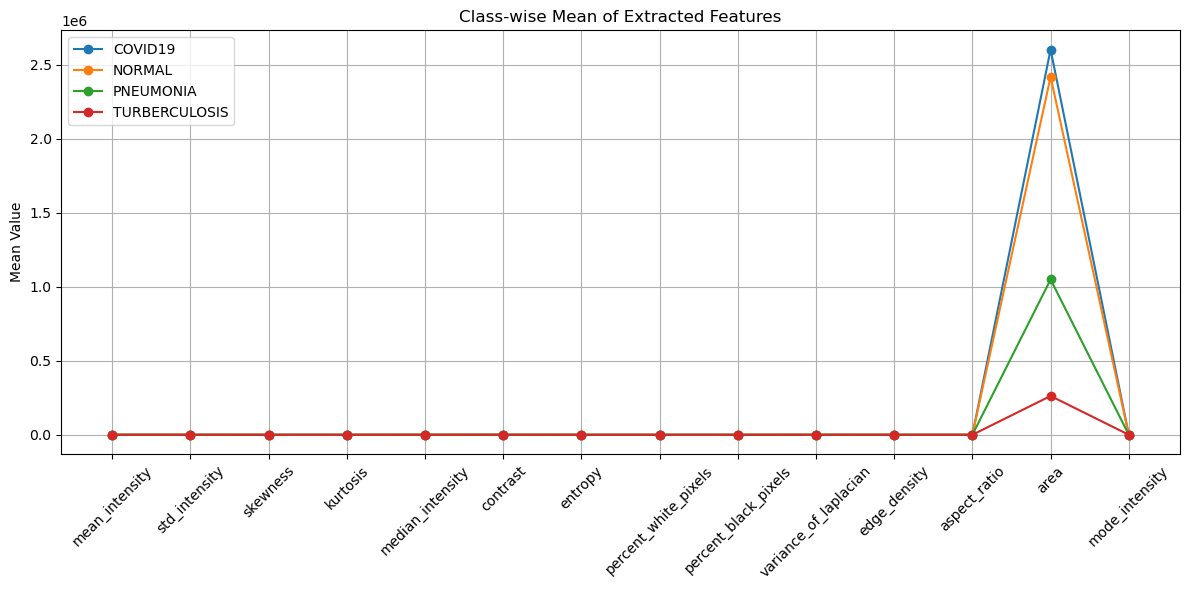

In [23]:
# Extracted Features Visualization

# Line Chart — Feature Means per Class
import matplotlib.pyplot as plt

# Compute class-wise means
class_feature_means = features_df.groupby("class")[feature_names].mean()

# Line plot
plt.figure(figsize=(12,6))
for cls in class_feature_means.index:
    plt.plot(feature_names, class_feature_means.loc[cls], marker='o', label=cls)
plt.xticks(rotation=45)
plt.title("Class-wise Mean of Extracted Features")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

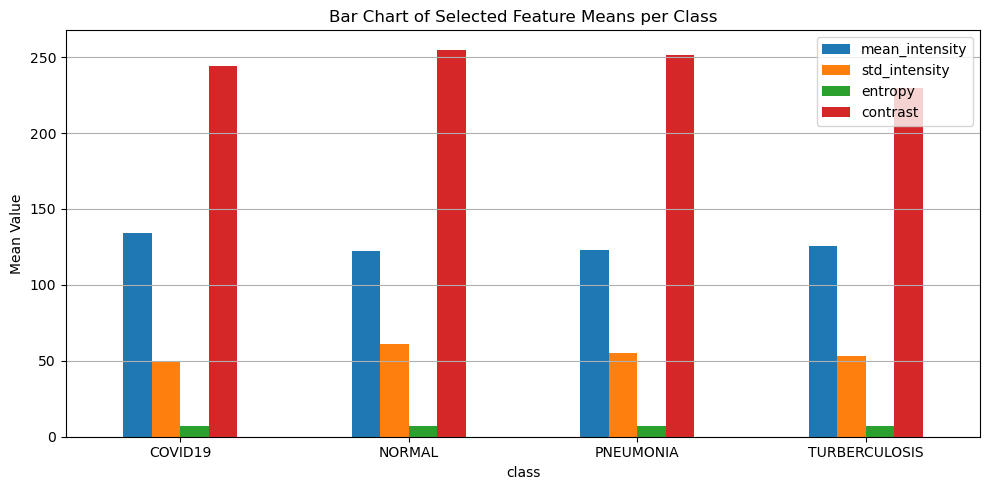

In [24]:
# Bar Chart — Mean of Selected Features per Class

selected = ["mean_intensity", "std_intensity", "entropy", "contrast"]
mean_vals = features_df.groupby("class")[selected].mean()

mean_vals.plot(kind='bar', figsize=(10,5))
plt.title("Bar Chart of Selected Feature Means per Class")
plt.ylabel("Mean Value")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

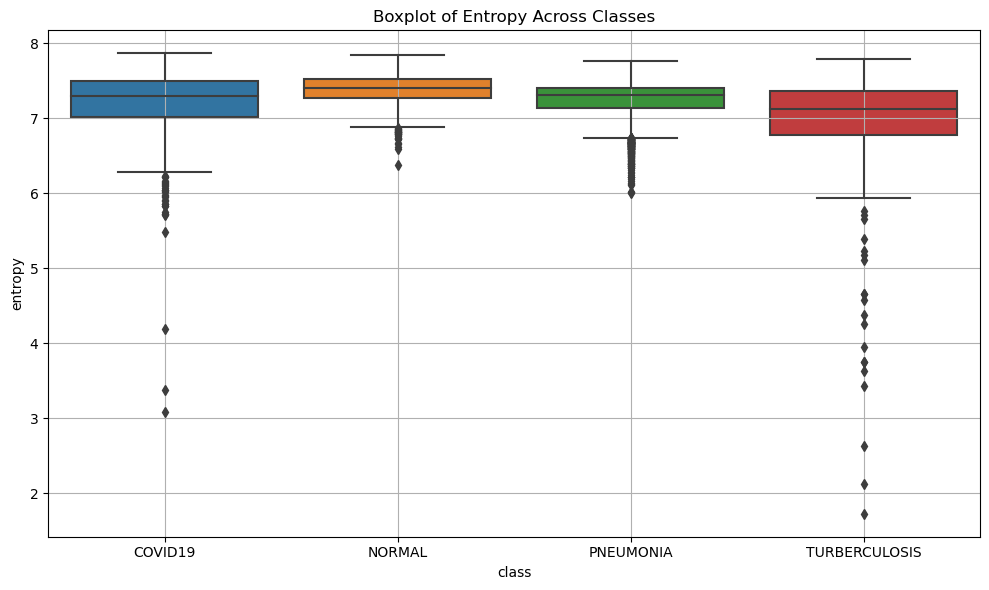

In [ ]:
# Box Plot — Feature Value Spread by Class
# We can repeat with any feature by changing y="entropy".

import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(data=features_df, x="class", y="entropy")
plt.title("Boxplot of Entropy Across Classes")
plt.grid(True)
plt.tight_layout()
plt.show()

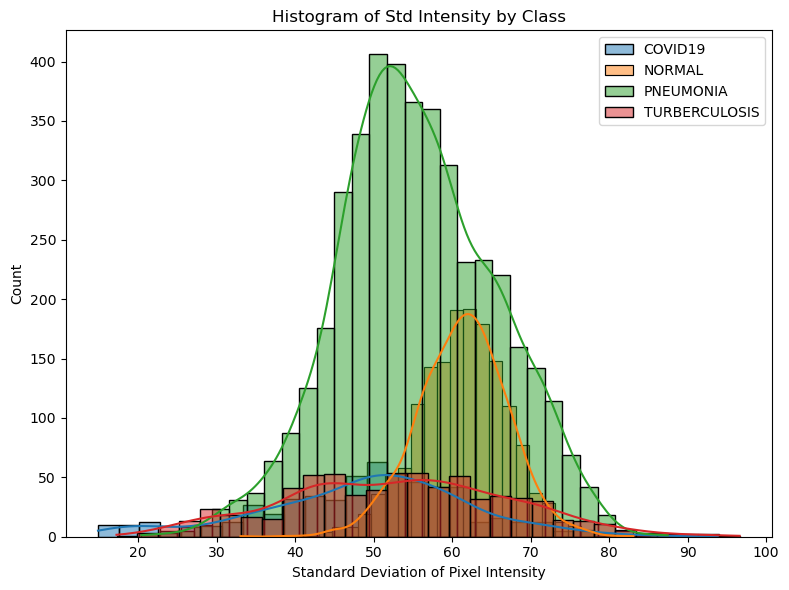

In [26]:
# Histogram — Feature Distribution

plt.figure(figsize=(8,6))
for cls in features_df['class'].unique():
    sns.histplot(features_df[features_df['class'] == cls]["std_intensity"], label=cls, kde=True, bins=30)
plt.title("Histogram of Std Intensity by Class")
plt.xlabel("Standard Deviation of Pixel Intensity")
plt.legend()
plt.tight_layout()
plt.show()

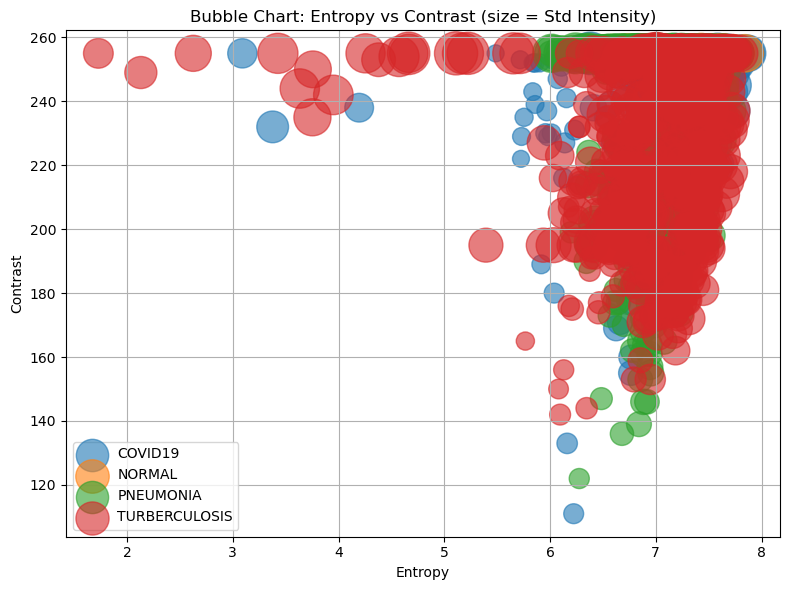

In [27]:
# Bubble Chart — 3 Feature Visualization

plt.figure(figsize=(8,6))
for cls in features_df['class'].unique():
    subset = features_df[features_df['class'] == cls]
    plt.scatter(subset["entropy"], subset["contrast"], s=subset["std_intensity"]*10, label=cls, alpha=0.6)
plt.xlabel("Entropy")
plt.ylabel("Contrast")
plt.title("Bubble Chart: Entropy vs Contrast (size = Std Intensity)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

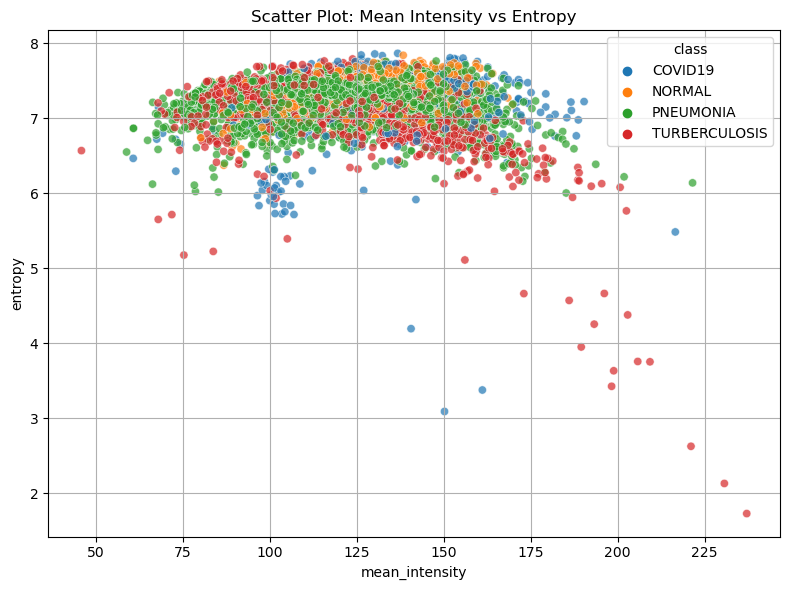

In [28]:
# Scatter Plot — Feature Pair

plt.figure(figsize=(8,6))
sns.scatterplot(data=features_df, x="mean_intensity", y="entropy", hue="class", alpha=0.7)
plt.title("Scatter Plot: Mean Intensity vs Entropy")
plt.grid(True)
plt.tight_layout()
plt.show()

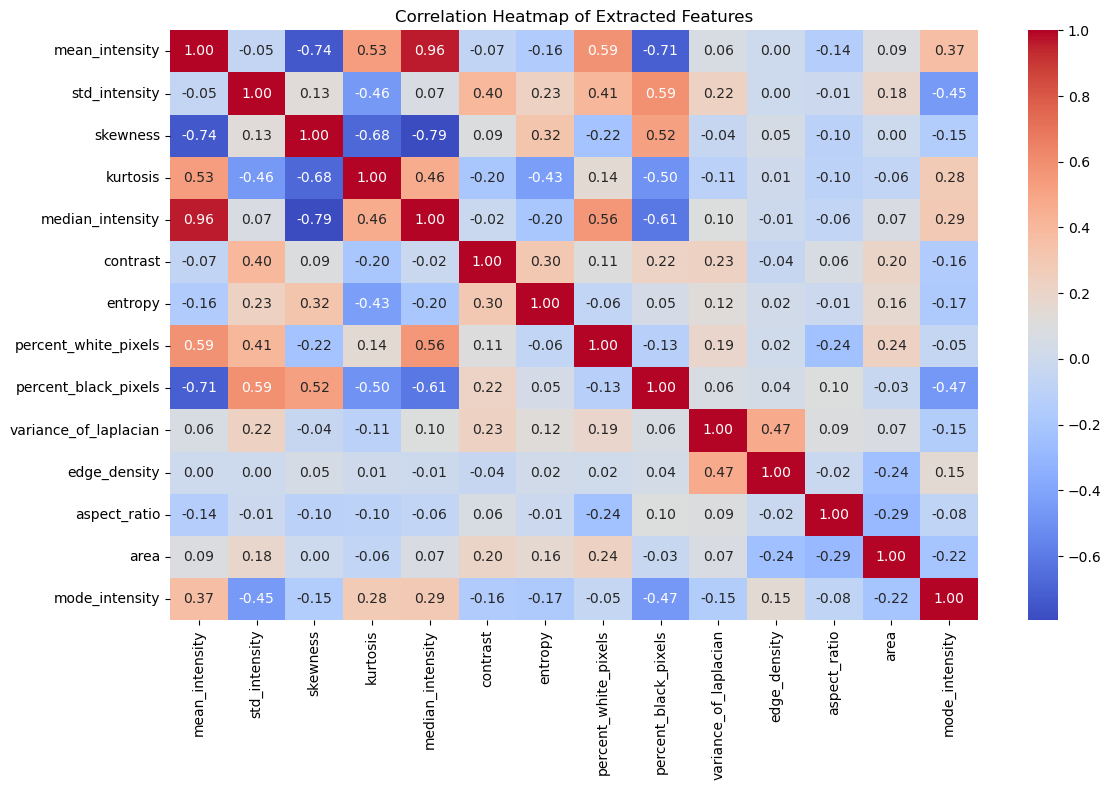

In [29]:
# Heat Map — Feature Correlation

corr = features_df[feature_names].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Extracted Features")
plt.tight_layout()
plt.show()

In [30]:
# Feature Selection

# Correlation Check (remove redundancy)

# Threshold for dropping correlated features
corr_matrix = features_df[feature_names].corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
print(f"Highly correlated features to drop: {to_drop}")
features_filtered = features_df.drop(columns=to_drop)
filtered_features = [col for col in feature_names if col not in to_drop]

Highly correlated features to drop: ['median_intensity']


In [31]:
# Filter Method — SelectKBest (ANOVA F-test)

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

X = features_filtered[filtered_features]
y = LabelEncoder().fit_transform(features_filtered["class"])

# Select top 10 features
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

selected_feature_mask = selector.get_support()
selected_features = X.columns[selected_feature_mask]

print(f"Top 10 selected features using ANOVA F-test: {list(selected_features)}")

Top 10 selected features using ANOVA F-test: ['std_intensity', 'contrast', 'entropy', 'percent_white_pixels', 'percent_black_pixels', 'variance_of_laplacian', 'edge_density', 'aspect_ratio', 'area', 'mode_intensity']


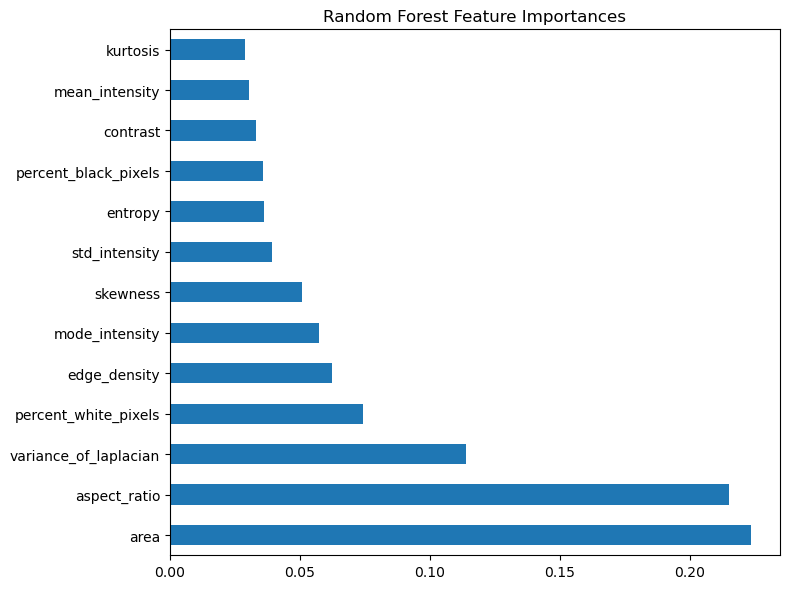

Top 10 features by RandomForest: ['area', 'aspect_ratio', 'variance_of_laplacian', 'percent_white_pixels', 'edge_density', 'mode_intensity', 'skewness', 'std_intensity', 'entropy', 'percent_black_pixels']


In [32]:
# Embedded Method — Random Forest Feature Importance

from sklearn.ensemble import RandomForestClassifier

# Fit model
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(8,6))
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# Cross-check with selected features
top_rf_features = importances.sort_values(ascending=False).head(10).index.tolist()
print(f"Top 10 features by RandomForest: {top_rf_features}")

In [33]:
# Take the union of selected features from both methods
final_features = list(set(selected_features) | set(top_rf_features))
print(f"Final selected features: {final_features}")

Final selected features: ['entropy', 'mode_intensity', 'percent_white_pixels', 'edge_density', 'std_intensity', 'aspect_ratio', 'variance_of_laplacian', 'contrast', 'percent_black_pixels', 'area', 'skewness']


In [ ]:
# Feature Transformation

# Standardization of Selected Features

from sklearn.preprocessing import StandardScaler

# Use only the selected features for transformation
X_selected = features_df[final_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Convert back to DataFrame for convenience
X_scaled_df = pd.DataFrame(X_scaled, columns=final_features)

# Add class column back for use in modeling/visualization
X_scaled_df["class"] = features_df["class"].values

print("✅ Standardization applied to selected features.")
X_scaled_df.head()

✅ Standardization applied to selected features.


,entropy,mode_intensity,percent_white_pixels,edge_density,std_intensity,aspect_ratio,variance_of_laplacian,contrast,percent_black_pixels,area,skewness,class
0,-1.799906,1.046278,-0.610807,-0.668953,-2.834835,-1.330998,-0.395111,-4.426514,-1.831138,2.003244,0.162338,COVID19
1,-0.099122,2.005266,3.919523,-0.599270,-0.303078,-0.124966,-0.565595,0.328052,-1.513993,1.184346,-1.007863,COVID19
2,-0.123994,-0.781441,0.632699,0.047039,0.673817,-1.306728,0.465278,0.328052,-0.353323,-0.254477,-0.766858,COVID19
3,0.111228,1.542695,2.258943,-0.743662,0.362676,-0.908536,-0.895139,-1.439672,-0.927828,0.182416,0.530421,COVID19
4,-0.326536,-0.781441,-0.107552,0.109884,-0.128166,-0.543700,-0.808673,0.328052,-0.752589,0.355042,-1.761983,COVID19


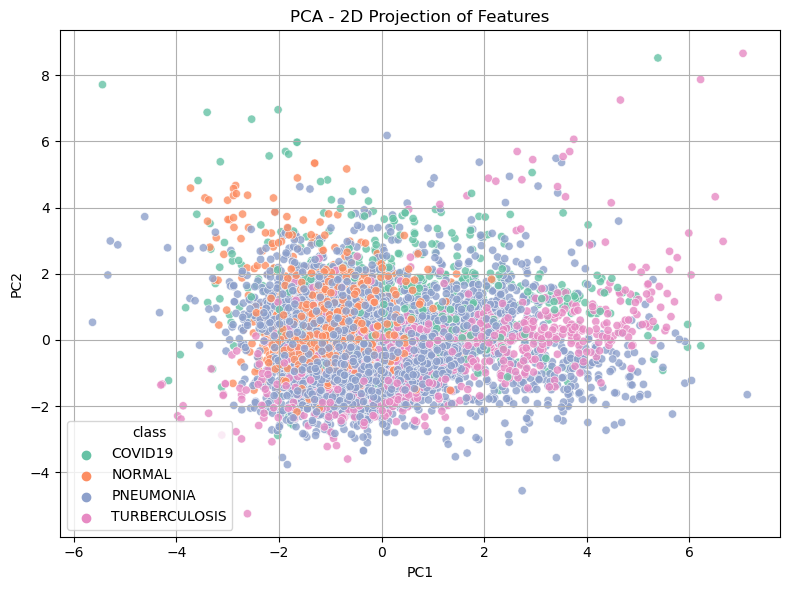

In [35]:
# Feature Reduction - PCA

# Apply PCA for Visualization (2D)
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Extract X and y
X = X_scaled_df.drop(columns=["class"])
y = X_scaled_df["class"]

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["class"] = y

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="class", palette="Set2", alpha=0.8)
plt.title("PCA - 2D Projection of Features")
plt.grid(True)
plt.tight_layout()
plt.show()

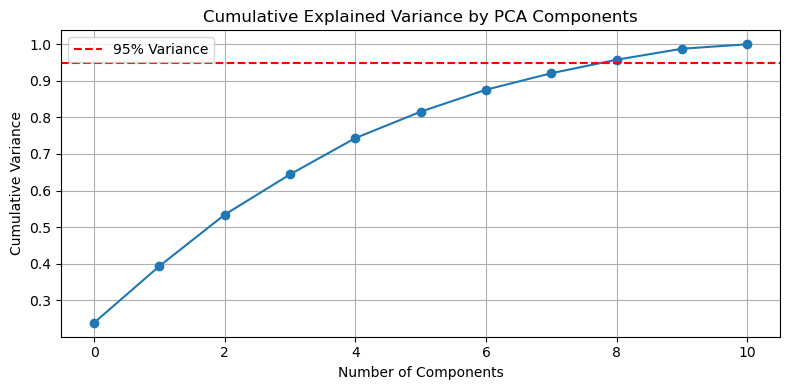

✅ Number of PCA components required to retain 95% variance: 9


In [36]:
# Variance Explained by PCA Components
# Re-run PCA on full set (not just 2D) to see variance
pca_full = PCA().fit(X)

# Plot explained variance
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= 0.95) + 1
print(f"✅ Number of PCA components required to retain 95% variance: {n_components_95}")

In [38]:
# Hypothesis Testing

# Run ANOVA on Selected Features
from scipy.stats import f_oneway

# Dictionary to store p-values
anova_results = {}

print("🔍 Running ANOVA on each selected feature:\n")
for feat in final_features:
    groups = [X_scaled_df[X_scaled_df["class"] == cls][feat] for cls in X_scaled_df["class"].unique()]
    f_val, p_val = f_oneway(*groups)
    anova_results[feat] = p_val
    significance = "✅ Significant" if p_val < 0.05 else "❌ Not Significant"
    print(f"{feat:<25} | p = {p_val:.5f} | {significance}")

# Sort by p-value
anova_sorted = dict(sorted(anova_results.items(), key=lambda x: x[1]))

🔍 Running ANOVA on each selected feature:

entropy                   | p = 0.00000 | ✅ Significant
mode_intensity            | p = 0.00000 | ✅ Significant
percent_white_pixels      | p = 0.00000 | ✅ Significant
edge_density              | p = 0.00000 | ✅ Significant
std_intensity             | p = 0.00000 | ✅ Significant
aspect_ratio              | p = 0.00000 | ✅ Significant
variance_of_laplacian     | p = 0.00000 | ✅ Significant
contrast                  | p = 0.00000 | ✅ Significant
percent_black_pixels      | p = 0.00000 | ✅ Significant
area                      | p = 0.00000 | ✅ Significant
skewness                  | p = 0.00000 | ✅ Significant


In [39]:
# Model Training and Evaluation

# Prepare Train / Val / Test Splits

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split based on original folders
train_df = X_scaled_df[features_df["split"] == "train"]
val_df   = X_scaled_df[features_df["split"] == "val"]
test_df  = X_scaled_df[features_df["split"] == "test"]

# Extract features and labels
X_train, y_train = train_df[final_features], train_df["class"]
X_val,   y_val   = val_df[final_features], val_df["class"]
X_test,  y_test  = test_df[final_features], test_df["class"]

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

In [42]:
# Evaluate All Models and Save Metrics

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

results = []

for name, model in models.items():
    model.fit(X_train, y_train_enc)
    preds = model.predict(X_val)

    acc = accuracy_score(y_val_enc, preds)
    prec = precision_score(y_val_enc, preds, average='weighted')
    rec = recall_score(y_val_enc, preds, average='weighted')
    f1 = f1_score(y_val_enc, preds, average='weighted')

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(results)

# Save to CSV
metrics_df.to_csv("model_evaluation_metrics.csv", index=False)
print("✅ Evaluation metrics saved to 'model_evaluation_metrics.csv'")

# Display metrics
metrics_df.sort_values(by="F1-Score", ascending=False)

✅ Evaluation metrics saved to 'model_evaluation_metrics.csv'


,Model,Accuracy,Precision,Recall,F1-Score
3,SVM (RBF Kernel),0.815789,0.885483,0.815789,0.805019
4,KNN,0.736842,0.808772,0.736842,0.739602
2,Random Forest,0.736842,0.883041,0.736842,0.726923
1,Decision Tree,0.736842,0.824561,0.736842,0.726817
0,Logistic Regression,0.710526,0.758990,0.710526,0.677368


In [43]:
# Identify Best Model Based on F1-Score
# Find best model based on highest F1-Score
best_model_name = metrics_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
print(f"🏆 Best model based on F1-Score: {best_model_name}")

# Retrieve the trained model
best_model = models[best_model_name]


🏆 Best model based on F1-Score: SVM (RBF Kernel)


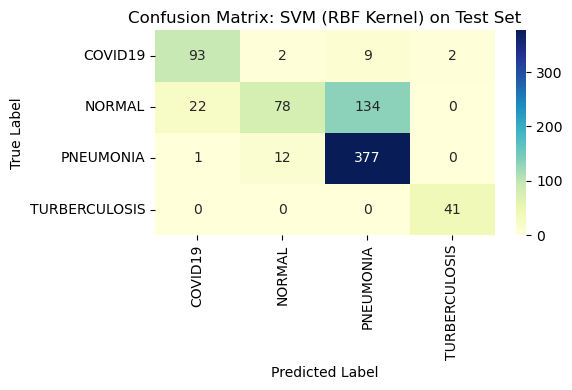

In [44]:
# Plot Confusion Matrix on Test Set

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_test_pred = best_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix: {best_model_name} on Test Set")
plt.tight_layout()
plt.show()